<a href="https://colab.research.google.com/github/ihawryluk/importations/blob/main/Thesis_seasonal_with_saving_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Renewal Equation simple model

Based on the code Sam shared on Zulip

Possibly some more useful code here https://github.com/MLGlobalHealth/uncertainity_infectious_diseases/blob/main/notebooks/SARS_COV1_inference_FINAL.ipynb



Trying to keep it simple for now, assumptions:

* fitting to infections only (not deaths)
* infections == cases
*


In [ ]:
!pip install numpyro

In [ ]:
!pip install dill

In [ ]:
import numpyro
import jax
numpyro.set_host_device_count(4)  # 4 cores
from jax import vmap
import jax.numpy as jnp
import jax.random as random

from numpyro.infer import Predictive
import numpyro.distributions as dist
import arviz as az
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan

from scipy.stats import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import arviz as az
import dill

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Simulate data

In [ ]:
def plot(R, mu, obs):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(obs, label = 'all cases')
  plt.plot(mu, label = 'importations')
  plt.legend()
  plt.xlabel('day')
  plt.ylabel('observed cases')
  plt.title('observed cases')
  plt.subplot(1,2,2)
  plt.plot(R, color = 'green', label='R')
  plt.xlabel('day')
  plt.ylabel('R')
  plt.title('R')
  plt.suptitle('simulated data')
  plt.tight_layout()
  plt.show()

In [ ]:
def simulate_g(n):
  g = gamma.pdf(np.arange(n), a=3, scale=1)
  g = g/np.sum(g)
  return g

# def simulate_R(n):
#   R = 1.15 + np.sin(0.15 * np.arange(n))
#   return R

# def simulate_R(n, inter, mult, div=1.0):
#   R = inter + np.sin(mult * np.arange(n)) / div
#   return R

def simulate_R(n, inter, mult, fun='sin'):
  # mult = 0 gives a constant R
  if fun == 'sin':
    R = inter + np.sin(mult * np.arange(n))
  elif fun == 'cos':
    R = inter + np.cos(mult * np.arange(n))
  return R

def simulate_mu(spikes_locs, spikes_vals):
  mu = np.zeros(n)
  # mu[0] = 5  # to make sure the epidemic starts before the importation
  # mu[spikes_locs] = spikes_vals
  lambda_p = 2 * np.pi / float(int(n/2))  # n/5 days periodicity
  j = np.arange(0,n)
  mu = 100 * (1 + np.sin(lambda_p * j))
  return mu.astype(int)
  # return mu

def compute_incidence_faster(R,g,mu):
    I = jnp.ones(n)
    for i in range(n):
        # I = jax.ops.index_update(I,i,R[i]*jnp.dot(I[i:],g[:n-i]))  # deprecated
        I = I.at[i].set(R[i]*jnp.dot(I[:i],np.flip(g[:i])) + mu[i])

    return I

In [ ]:
# def simulate_R(n, inter, mult, div=1.0):
#   R = inter + np.sin(mult * np.arange(n)) / div
#   return R

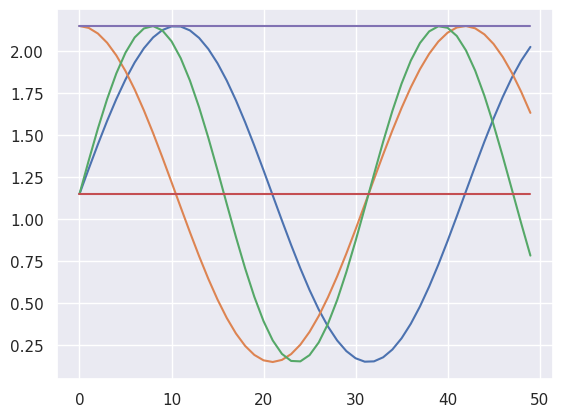

In [ ]:
n = 50
plt.plot(simulate_R(n, 1.15, 0.15,'sin'))
plt.plot(simulate_R(n, 1.15, 0.15,'cos'))
plt.plot(simulate_R(n, 1.15, 0.2,'sin'))
plt.plot(simulate_R(n, 1.15, 0.0, 'sin'))
plt.plot(simulate_R(n, 1.15, 0.0, 'cos'))


In [ ]:
def simulate_renewal(spikes_locs, spikes_vals, inter, mult, fun='sin', n=100):

  g = simulate_g(n)#.astype(int)   # discrete?
  mu = simulate_mu(spikes_locs, spikes_vals)
  R = simulate_R(n, inter, mult, fun)

  incidence = compute_incidence_faster(R,g,mu)
  obs = dist.Poisson(incidence).sample(random.PRNGKey(0))

  return R, incidence, g, mu, obs

In [ ]:
# scenarios_names = ['placeholder',
#                    r'second spike when $R_t$ decreasing, equal spikes',
#                    r'second spike when $R_t$ decreasing, first spike higher',
#                    r'second spike when $R_t$ decreasing, second spike higher',
#                    r'second spike when $R_t$ increasing but inc ~ 0, equal spikes',
#                    r'second spike when $R_t$ increasing but inc ~ 0, first spike higher',
#                    r'second spike when $R_t$ increasing but inc ~ 0, second spike higher',
#                   r'second spike when $R_t$ increasing, equal spikes',
#                    r'second spike when $R_t$ increasing, first spike higher',
#                    r'second spike when $R_t$ increasing, second spike higher',
#                    ]

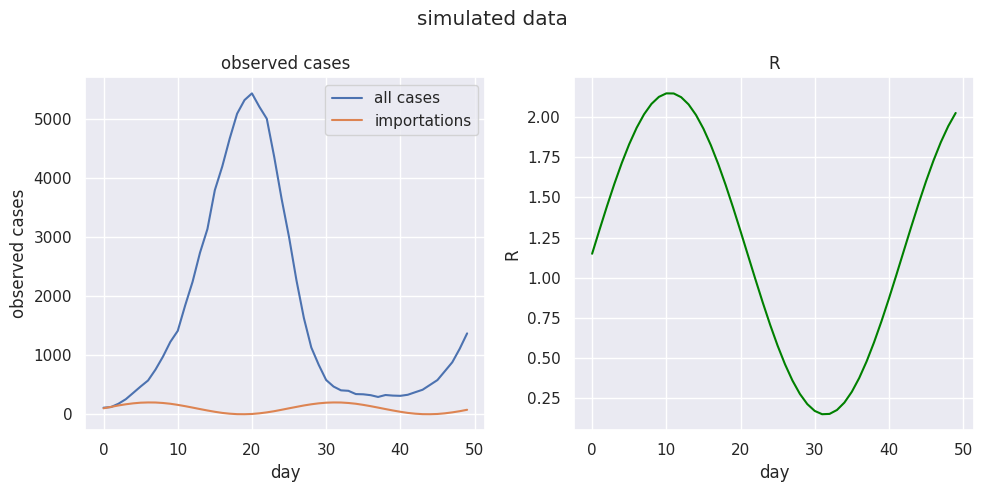

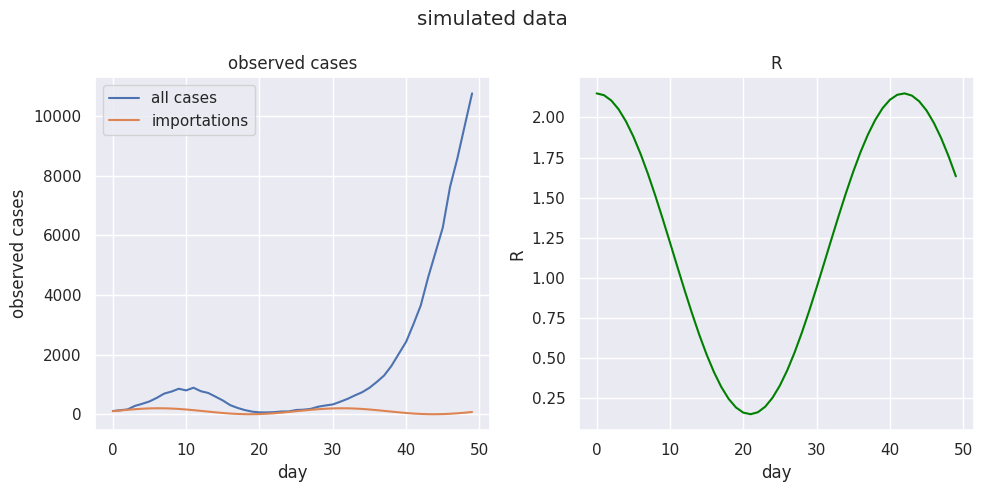

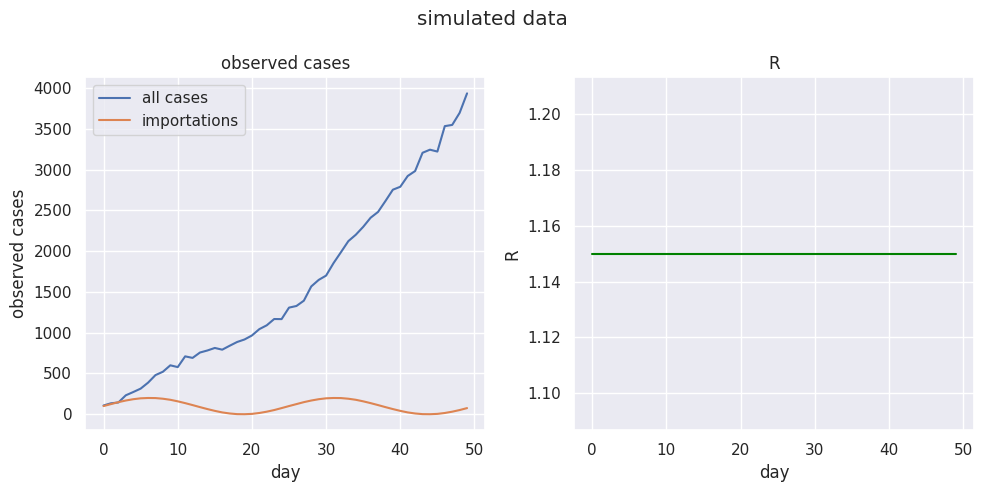

In [ ]:
inter = 1.15
mult1 = 0.15
mult2 = 0.00

fun1 = 'sin'
fun2 = 'cos'

# inter = 1.15
# mult = 0.15
# div = 1

n = 50

R1, inc1, g1, mu1, obs1 = simulate_renewal([0], [0], inter, mult1, fun1, n=n)
R2, inc2, g2, mu2, obs2 = simulate_renewal([0], [0], inter, mult1, fun2, n=n)
R3, inc3, g3, mu3, obs3 = simulate_renewal([0], [0], inter, mult2, fun1, n=n)

# R, inc, g, mu, obs = simulate_renewal(mu=None)

plot(R1, mu1, obs1)
plot(R2, mu2, obs2)
plot(R3, mu3, obs3)

In [ ]:
# R4, inc4, g4, mu4, obs4 = simulate_renewal(spikes_locs2, spikes_vals1, inter, mult, div, n=n)
# R5, inc5, g5, mu5, obs5 = simulate_renewal(spikes_locs2, spikes_vals2, inter, mult, div, n=n)
# R6, inc6, g6, mu6, obs6 = simulate_renewal(spikes_locs2, spikes_vals3, inter, mult, div, n=n)
# # R, inc, g, mu, obs = simulate_renewal(mu=None)

# plot(R4, mu4, obs4)
# plot(R5, mu5, obs5)
# plot(R6, mu6, obs6)

In [ ]:
# R7, inc7, g7, mu7, obs7 = simulate_renewal(spikes_locs3, spikes_vals1, inter, mult, div, n=n)
# R8, inc8, g8, mu8, obs8 = simulate_renewal(spikes_locs3, spikes_vals2, inter, mult, div, n=n)
# R9, inc9, g9, mu9, obs9 = simulate_renewal(spikes_locs3, spikes_vals3, inter, mult, div, n=n)
# # R, inc, g, mu, obs = simulate_renewal(mu=None)

# plot(R7, mu7, obs7)
# plot(R8, mu8, obs8)
# plot(R9, mu9, obs9)

## Save the simulated data

In [ ]:
# get a dataframe with R_T
Rt_df = pd.DataFrame(columns = ['R1', 'R2', 'R3'])
Rt_df['R1'] = R1
Rt_df['R2'] = R2
Rt_df['R3'] = R3
# print(Rt_df)
# get a dataframe with incidence
y_df = pd.DataFrame(columns = ['y1', 'y2', 'y3'])
y_df['y1'] = obs1
y_df['y2'] = obs2
y_df['y3'] = obs3
# print(y_df)
# get a dataframe with mu
mu_df = pd.DataFrame(columns = ['mu1', 'mu2', 'mu3'])
mu_df['mu1'] = mu1
mu_df['mu2'] = mu2
mu_df['mu3'] = mu3

# print(y_df)

In [ ]:
Rt_df.to_csv('/content/drive/My Drive/Colab Notebooks/importations/Data/sim_seasonal_Rt.csv', index=False)
y_df.to_csv('/content/drive/My Drive/Colab Notebooks/importations/Data/sim_seasonal_y.csv', index=False)
mu_df.to_csv('/content/drive/My Drive/Colab Notebooks/importations/Data/sim_seasonal_mu.csv', index=False)

In [ ]:
ls /content/drive/MyDrive/Colab\ Notebooks/importations/Data/

Double_spike/  sim_double_spike_mu.csv  sim_double_spike_y.csv  sim_seasonal_Rt.csv
Seasonal/      sim_double_spike_Rt.csv  sim_seasonal_mu.csv     sim_seasonal_y.csv


# 2. Inference

## Model

In [ ]:
def renewal(y,g,r_prior = 1.0):
# y -- observed data
# g -- generation/serial interval
    def compute_incidence_faster(R,g,mu):
        I = jnp.ones(n)
        for i in range(n):
            # I = jax.ops.index_update(I,i,R[i]*jnp.dot(I[i:],g[:n-i]))  # deprecated
            I = I.at[i].set(R[i]*jnp.dot(I[:i],np.flip(g[:i])) + mu[i])
        return I

    n = y.size

    # priors
    sigma_R = numpyro.sample("sigma_R", dist.Exponential(r_prior))   # mean of this is 1/lambda, so to make it smaller, make lambda bigger# 5 fits perf
    # sigma_R = .5  # 1 is kinda good but still not solving our problem, 0.5 is perfect

    sigma_mu = numpyro.sample("sigma_mu", dist.Gamma(.1))
    mult_mu = 1.0#numpyro.sample("mult_mu", dist.HalfNormal(4))

    theta = numpyro.sample("theta", dist.Uniform(0,1))
    temp = numpyro.sample("temp", dist.Uniform(0,1))
    bin_mu = numpyro.sample("bin_mu", dist.RelaxedBernoulli(temp, probs=theta * jnp.ones(n)))   # so seems that this gives a tuple
    # bin_mu = numpyro.sample("bin_mu", dist.RelaxedBernoulli(0.5, probs=theta), (n,))   # so seems that this gives a tuple

    # 1d random walk for R
    R_d = numpyro.sample("R_d", dist.GaussianRandomWalk(scale=sigma_R, num_steps=n))
    R = numpyro.deterministic('R',jnp.exp(R_d)) # prevents from negative values

    # 1d random walk for importations
    mu_d = numpyro.sample("mu_d", dist.GaussianRandomWalk(scale=sigma_mu, num_steps=n))
    mu = numpyro.deterministic('mu', jnp.multiply(bin_mu,jnp.exp(mu_d)))

    # mu = numpyro.deterministic('mu', bin_mu * jnp.exp(mu_d))
    # mu = numpyro.deterministic('mu', jnp.exp(mu_d))

    # incidence
    incidence = numpyro.deterministic('incidence',compute_incidence_faster(R,g,mu))

    # observed data
    numpyro.sample('obs', dist.Poisson(incidence), obs=y)

In [ ]:
def renewal_seas_explicit(y,g,r_prior = 1.0):
# y -- observed data
# g -- generation/serial interval
    def compute_incidence_faster(R,g,mu):
        I = jnp.ones(n)
        for i in range(n):
            # I = jax.ops.index_update(I,i,R[i]*jnp.dot(I[i:],g[:n-i]))  # deprecated
            I = I.at[i].set(R[i]*jnp.dot(I[:i],np.flip(g[:i])) + mu[i])
        return I

    n = y.size

    # priors
    sigma_R = numpyro.sample("sigma_R", dist.Exponential(r_prior))   # mean of this is 1/lambda, so to make it smaller, make lambda bigger# 5 fits perf
    # sigma_R = .5  # 1 is kinda good but still not solving our problem, 0.5 is perfect

    # sigma_mu = numpyro.sample("sigma_mu", dist.Gamma(.1))
    # mult_mu = 1.0#numpyro.sample("mult_mu", dist.HalfNormal(4))
    sigma_mu = numpyro.sample("sigma_mu", dist.TruncatedNormal(low=1, loc=1, scale=10))
    mult_mu = numpyro.sample("mult_mu", dist.TruncatedNormal(low=1, loc=1, scale=100))

    # theta = numpyro.sample("theta", dist.Uniform(0,1))
    # temp = numpyro.sample("temp", dist.Uniform(0,1))
    # bin_mu = numpyro.sample("bin_mu", dist.RelaxedBernoulli(temp, probs=theta * jnp.ones(n)))   # so seems that this gives a tuple
    # bin_mu = numpyro.sample("bin_mu", dist.RelaxedBernoulli(0.5, probs=theta), (n,))   # so seems that this gives a tuple

    # 1d random walk for R
    R_d = numpyro.sample("R_d", dist.GaussianRandomWalk(scale=sigma_R, num_steps=n))
    R = numpyro.deterministic('R',jnp.exp(R_d)) # prevents from negative values

    # 1d random walk for importations
    # mu_d = numpyro.sample("mu_d", dist.GaussianRandomWalk(scale=sigma_mu, num_steps=n))
    # mu = numpyro.deterministic('mu', jnp.multiply(bin_mu,jnp.exp(mu_d)))
    lambda_p = 2 * jnp.pi / (n / sigma_mu) # n/5 days periodicity
    j = jnp.arange(0,n)
    mu = numpyro.deterministic('mu', mult_mu * (1 + jnp.sin(lambda_p * j)))
    # mu = numpyro.deterministic('mu', mult_mu * (1 + jnp.sin(sigma_mu * j)))

    # mu = numpyro.deterministic('mu', bin_mu * jnp.exp(mu_d))
    # mu = numpyro.deterministic('mu', jnp.exp(mu_d))

    # incidence
    incidence = numpyro.deterministic('incidence',compute_incidence_faster(R,g,mu))

    # observed data
    numpyro.sample('obs', dist.Poisson(incidence), obs=y)

## Fit the model

In [ ]:
def fit(model, obs, g, r_prior=1.0):
  mcmc = MCMC(NUTS(model, target_accept_prob=0.8),
              num_chains=4,
              num_warmup=1000,
              num_samples=20000,
              progress_bar=False)
              # num_warmup=00,
              # num_samples=500,
              # progress_bar=True)
  mcmc.run(random.PRNGKey(0), y=jnp.array(obs), g=jnp.array(g), r_prior=r_prior)
  samples = mcmc.get_samples()
  return samples, mcmc


In [ ]:
# mcmc = MCMC(NUTS(renewal, target_accept_prob=0.8),
#               num_chains=4,
#               num_warmup=500,
#               num_samples=1000,
#               progress_bar=False)
# mcmc.run(random.PRNGKey(0), y=jnp.array(obs), g=jnp.array(g), r_prior=0.5)
# mcmc.run(random.PRNGKey(0), y=jnp.array(obs), g=jnp.array(g), r_prior=50.0)

# samples = mcmc.get_samples()
# mcmc.print_summary()
r_pior = 0.1


samples1, mcmc1 = fit(renewal, obs1, g1, r_prior=r_pior)
samples2, mcmc2 = fit(renewal, obs2, g2, r_prior=r_pior)
samples3, mcmc3 = fit(renewal, obs3, g3, r_prior=r_pior)

In [ ]:
r_pior = 0.1

# samples1e = fit(renewal_seas_explicit, obs1, g1, r_prior=r_pior)
# samples2e = fit(renewal_seas_explicit, obs2, g2, r_prior=r_pior)
# samples3e = fit(renewal_seas_explicit, obs3, g3, r_prior=r_pior)
samples1e, mcmc1e = fit(renewal_seas_explicit, obs1, g1, r_prior=r_pior)
samples2e, mcmc2e = fit(renewal_seas_explicit, obs2, g2, r_prior=r_pior)
samples3e, mcmc3e = fit(renewal_seas_explicit, obs3, g3, r_prior=r_pior)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_1.pkl', 'wb') as f:
    dill.dump(mcmc1, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_2.pkl', 'wb') as f:
    dill.dump(mcmc2, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_3.pkl', 'wb') as f:
    dill.dump(mcmc3, f)

with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_1e.pkl', 'wb') as f:
    dill.dump(mcmc1e, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_2e.pkl', 'wb') as f:
    dill.dump(mcmc2e, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_3e.pkl', 'wb') as f:
    dill.dump(mcmc3e, f)


## Plot and compare results

In [ ]:
def plot_sigmas(samples):
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.hist(samples['sigma_mu'], label = 'posterior')
  # plt.axvline(x = sigma_mu, color='red', label = 'true')
  plt.legend()
  plt.xlabel('sigma_mu')

  plt.subplot(1,3,2)
  plt.hist(samples['sigma_R'], label = 'posterior')
  # plt.axvline(x = sigma_R, color='red', label = 'true')
  plt.legend()
  plt.xlabel('sigma_R')

  # plt.subplot(1,3,3)
  # plt.hist(samples['mult_mu'], label = 'posterior')
  # # plt.axvline(x = 5, color='red', label = 'true')
  # plt.legend()
  # plt.xlabel('mult_mu')

  plt.subplot(1,3,3)
  plt.hist(samples['theta'], label = 'posterior')
  # plt.axvline(x = 5, color='red', label = 'true')
  plt.legend()
  plt.xlabel('theta')

  plt.show()

def plot_posterior(samples, R, mu, inc, title=None):
  plt.figure(figsize=(15,5))

  x = np.arange(n)
  plt.subplot(1,3,1)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['R'], 5, axis=0), np.percentile(samples['R'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['R'], 50, axis=0), label='post median', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = 'true')
  plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('days')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$')

  plt.subplot(1,3,2)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['mu'], 5, axis=0), np.percentile(samples['mu'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['mu'], 50, axis=0), label='post median', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = 'true')
  plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('days')
  plt.ylabel('# importations')
  plt.title('Importations')

  plt.subplot(1,3,3)
  # plt.plot(samples['incidence'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['incidence'], 5, axis=0), np.percentile(samples['incidence'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['incidence'], 50, axis=0), label='post median', color='tab:blue')
  plt.plot(inc, color = 'red', alpha=1.0, label = 'true')
  # plt.ylim(0,samples['incidence'].max())
  plt.legend()
  plt.xlabel('days')
  plt.ylabel('# new cases')
  plt.title('Incidence')


  if title is None:
    plt.suptitle('Posterior predictive')
  else:
    plt.suptitle('Posterior predictive, ' + title)
  plt.tight_layout()
  plt.show()

In [ ]:
# plot_sigmas(samples)

In [ ]:
# plot_posterior(samples, 'R_t variance inferred')

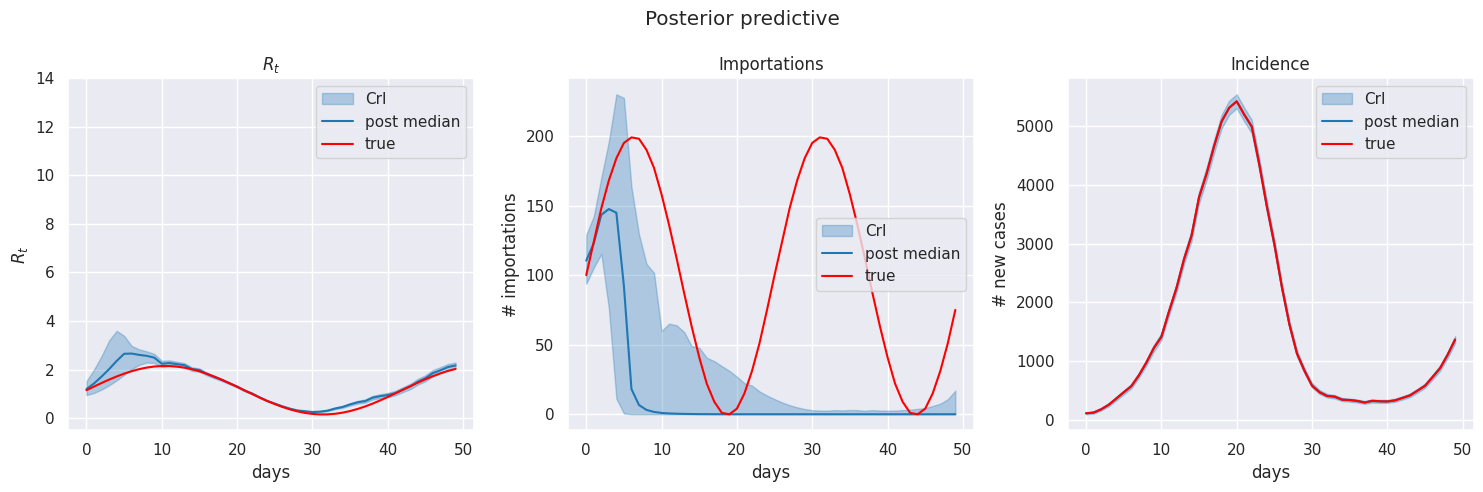

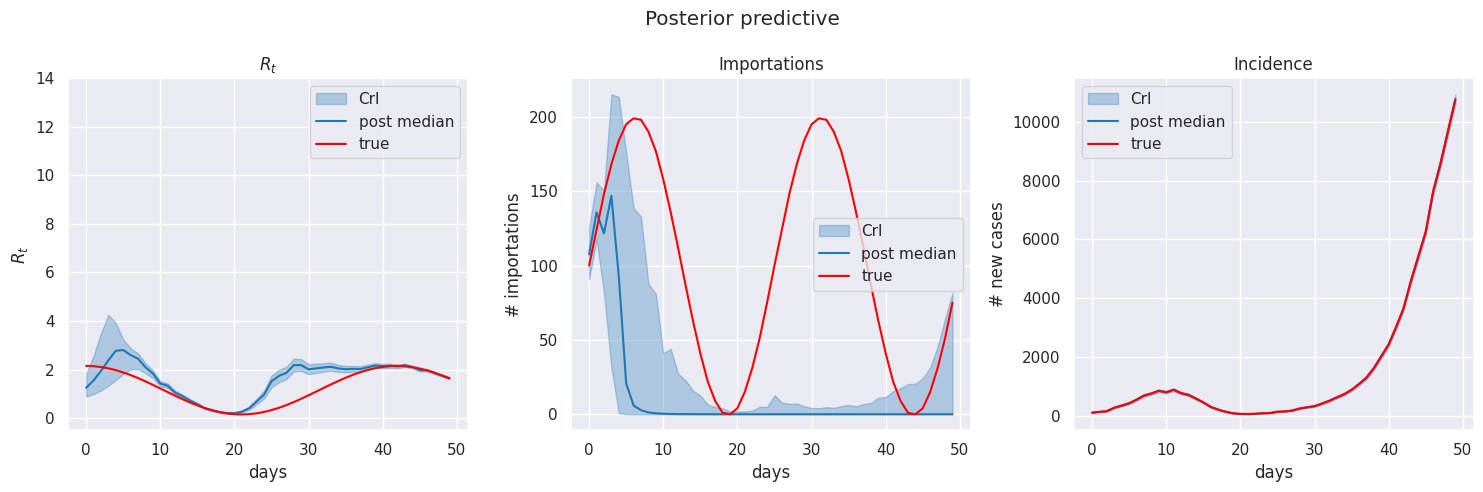

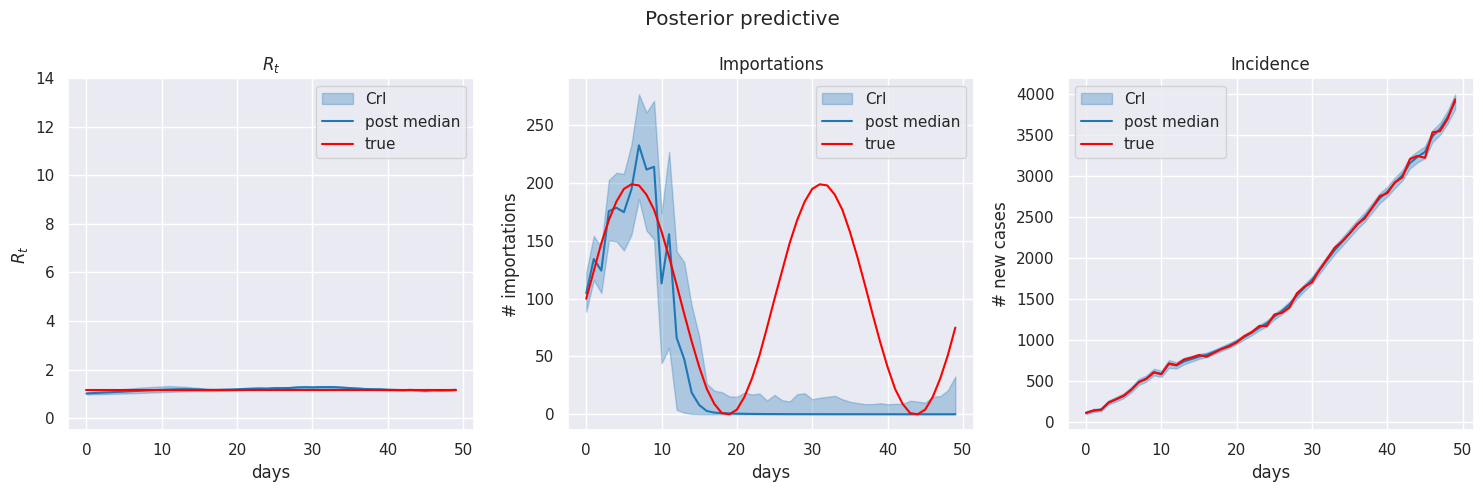

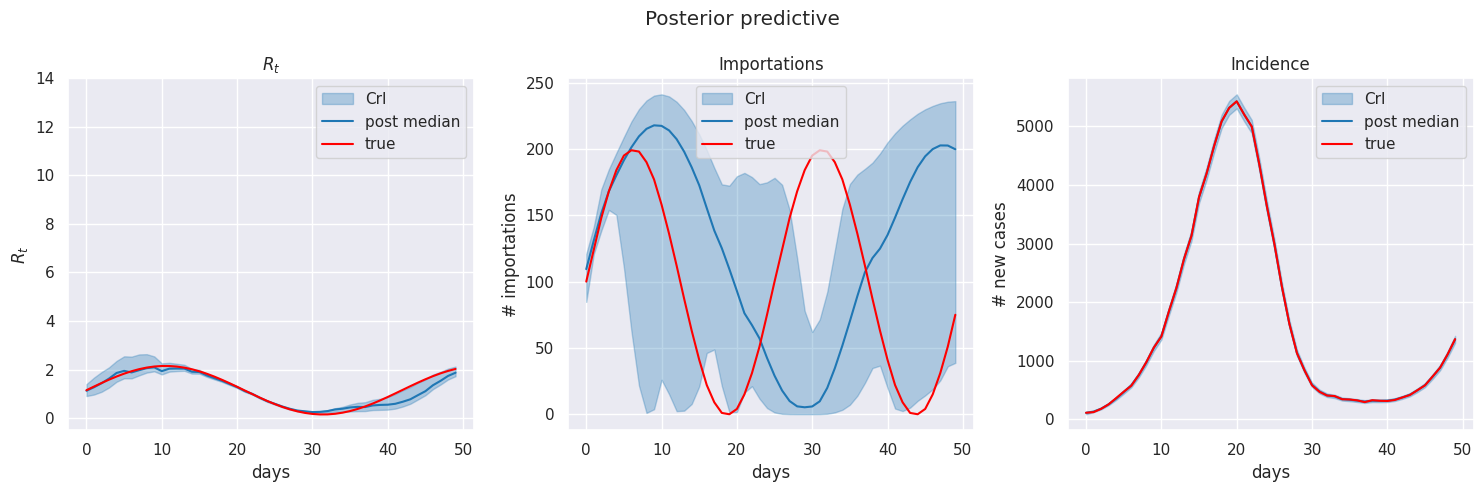

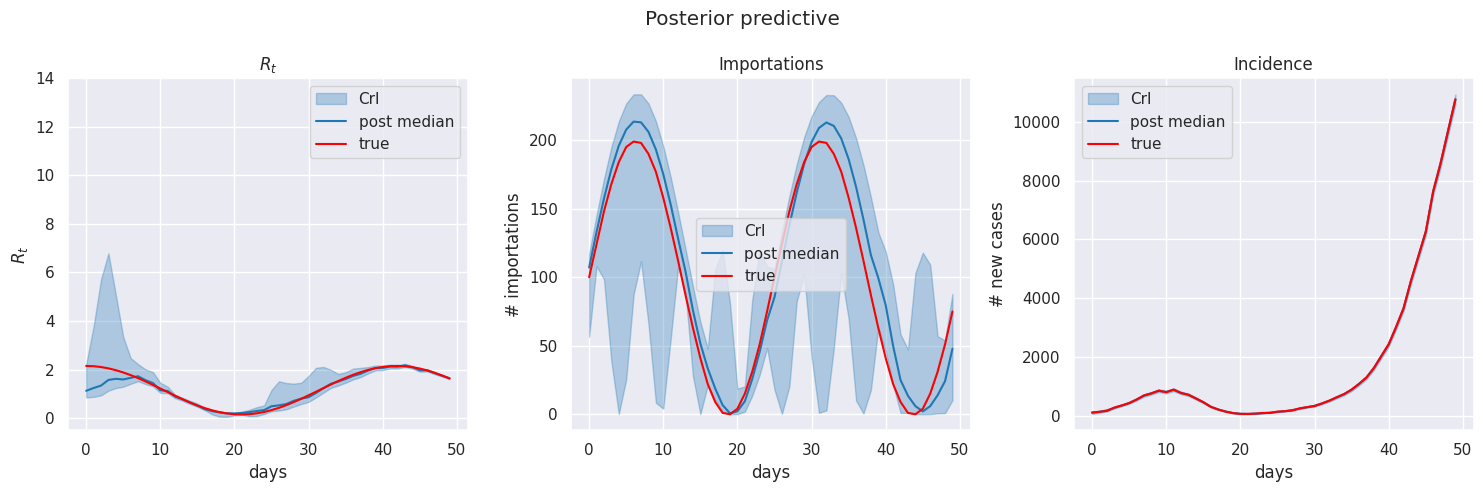

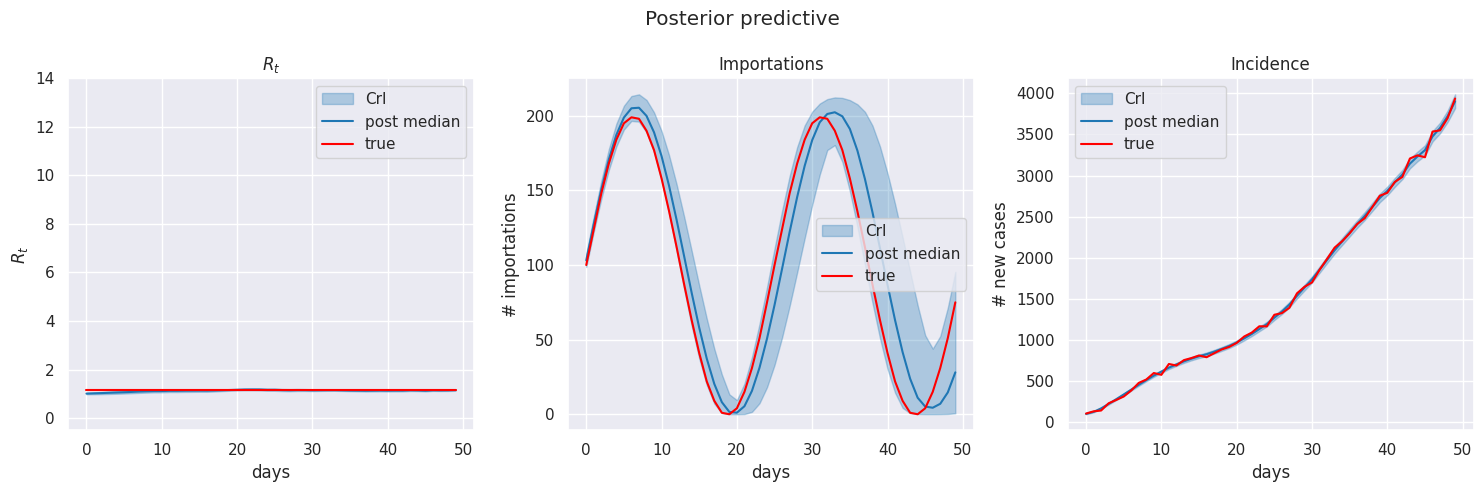

In [ ]:
plot_posterior(samples1, R1, mu1, obs1)
plot_posterior(samples2, R2, mu2, obs2)
plot_posterior(samples3, R3, mu3, obs3)

plot_posterior(samples1e, R1, mu1, obs1)
plot_posterior(samples2e, R2, mu2, obs2)
plot_posterior(samples3e, R3, mu3, obs3)

# plot_posterior(samples7, R7, mu7, obs7)
# plot_posterior(samples8, R8, mu8, obs8)
# plot_posterior(samples9, R9, mu9, obs9)

In [ ]:
r_pior = 100.0

samples10, mcmc10 = fit(renewal, obs1, g1, r_prior=r_pior)
samples20, mcmc20 = fit(renewal, obs2, g2, r_prior=r_pior)
samples30, mcmc30 = fit(renewal, obs3, g3, r_prior=r_pior)


with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_10.pkl', 'wb') as f:
    dill.dump(mcmc10, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_20.pkl', 'wb') as f:
    dill.dump(mcmc20, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_30.pkl', 'wb') as f:
    dill.dump(mcmc30, f)


In [ ]:
r_pior = 100.0

samples10e, mcmc10e = fit(renewal_seas_explicit, obs1, g1, r_prior=r_pior)
samples20e, mcmc20e = fit(renewal_seas_explicit, obs2, g2, r_prior=r_pior)
samples30e, mcmc30e = fit(renewal_seas_explicit, obs3, g3, r_prior=r_pior)

with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_10e.pkl', 'wb') as f:
    dill.dump(mcmc10e, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_20e.pkl', 'wb') as f:
    dill.dump(mcmc20e, f)
with open('/content/drive/My Drive/Colab Notebooks/importations/Data/Seasonal/mcmc_30e.pkl', 'wb') as f:
    dill.dump(mcmc30e, f)

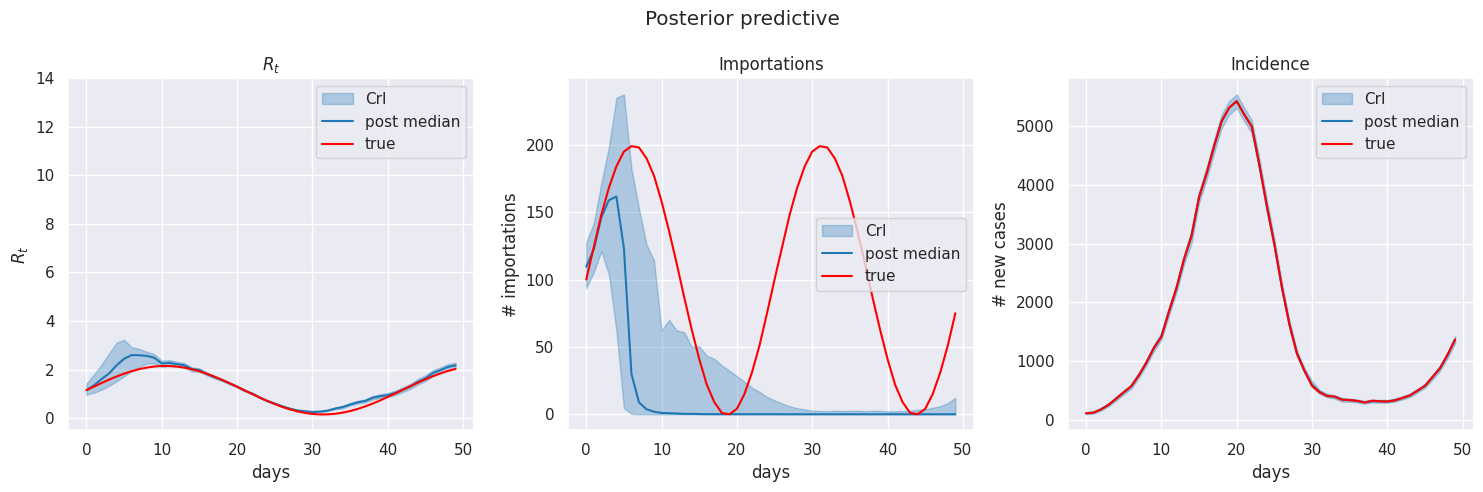

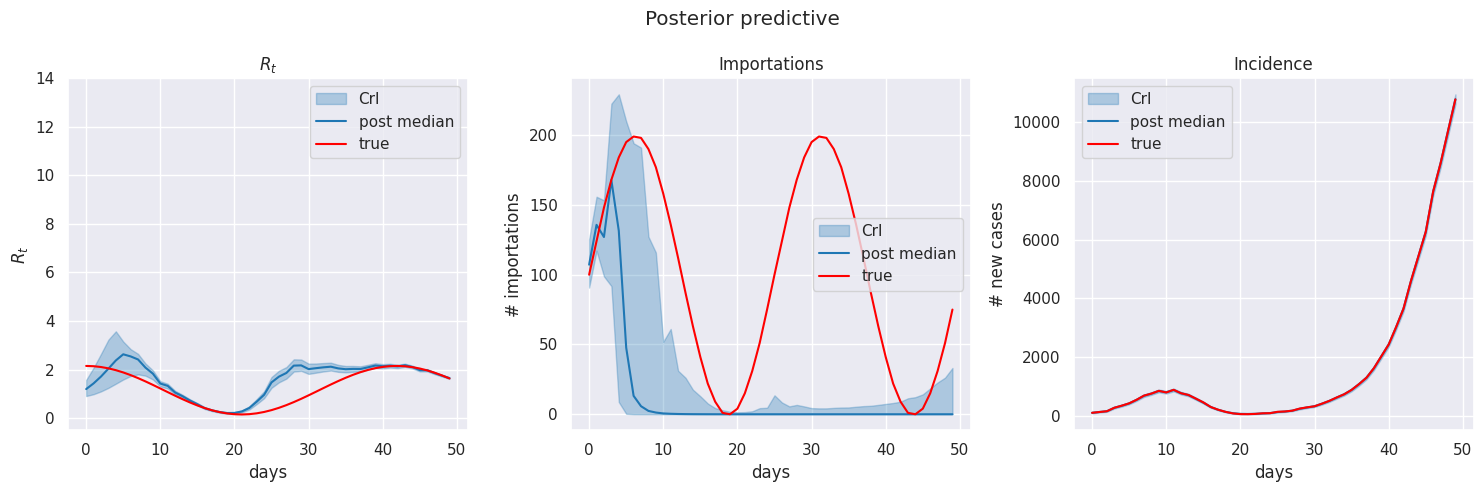

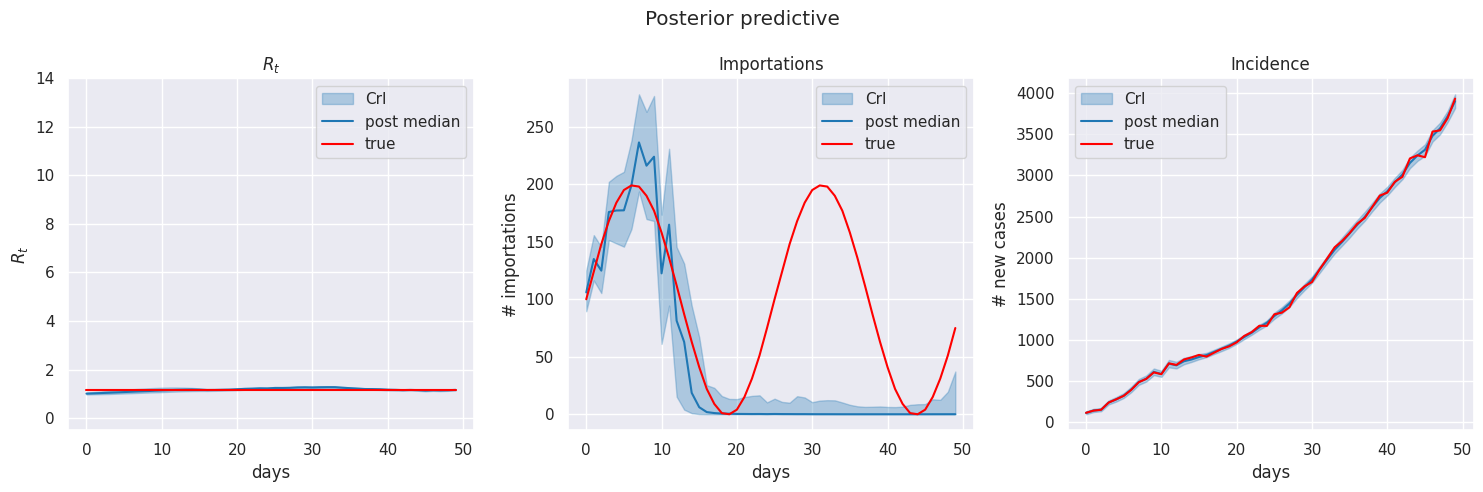

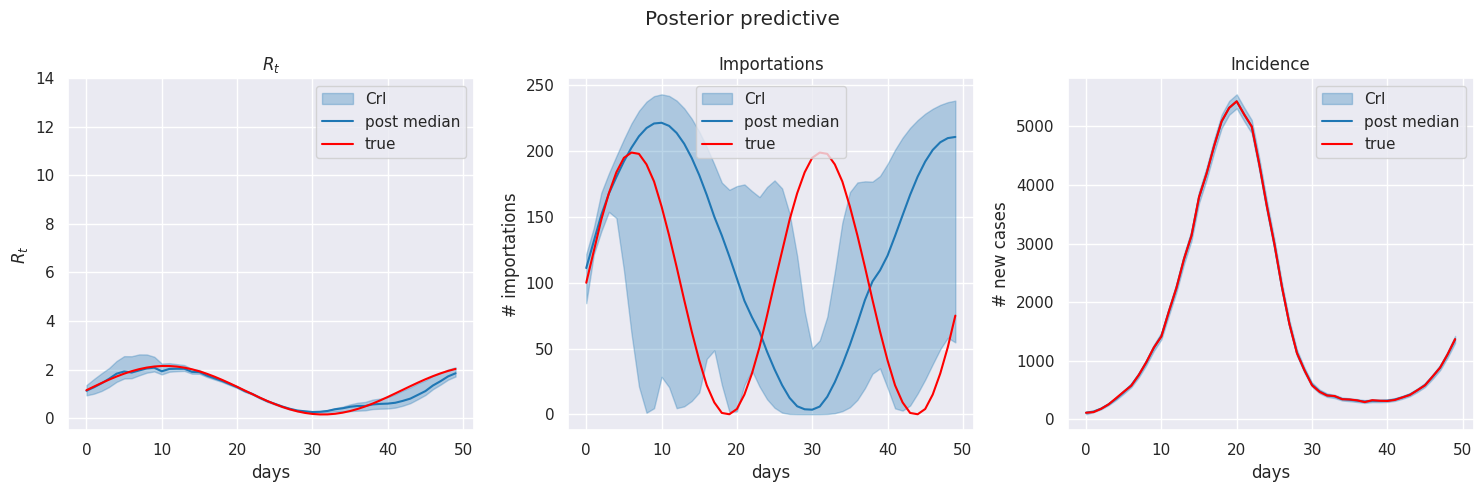

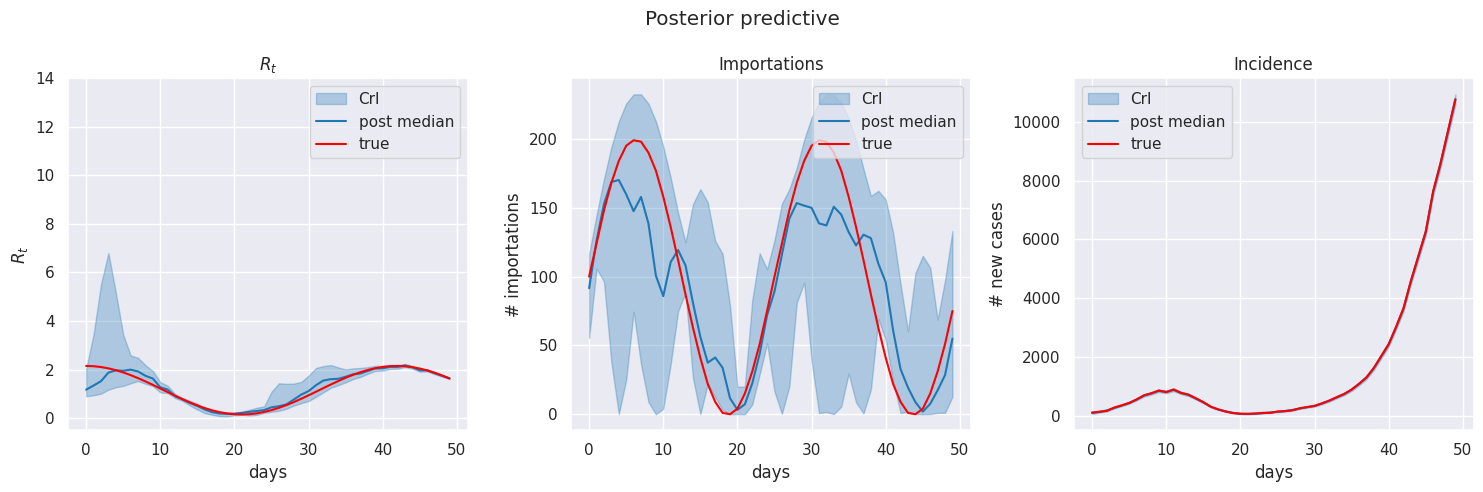

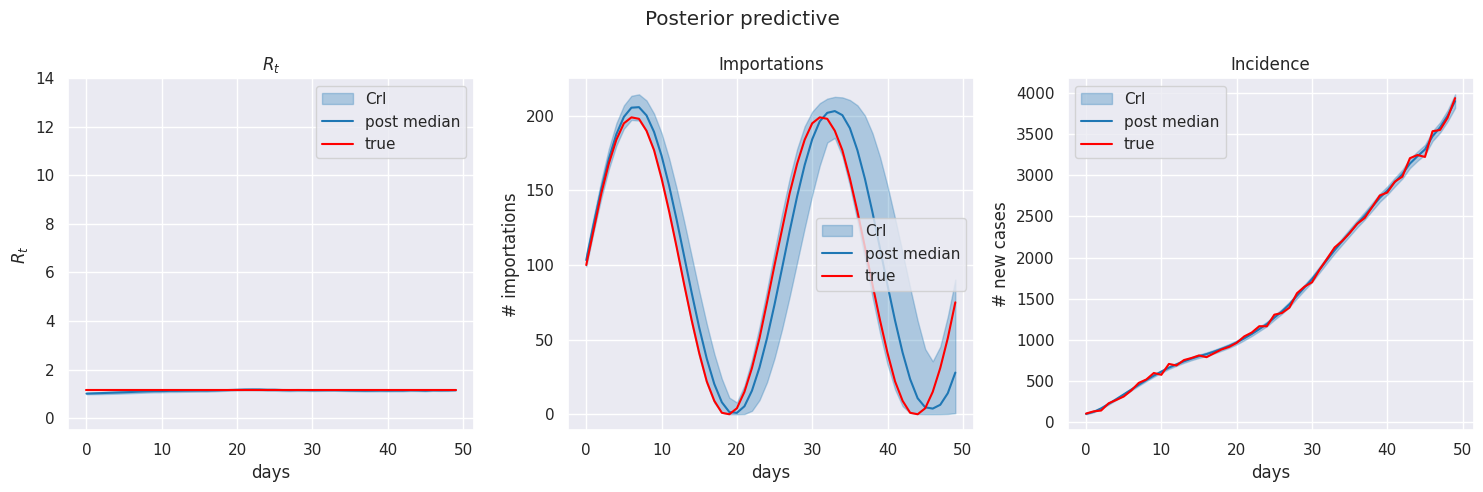

In [ ]:
plot_posterior(samples10, R1, mu1, obs1)
plot_posterior(samples20, R2, mu2, obs2)
plot_posterior(samples30, R3, mu3, obs3)

plot_posterior(samples10e, R1, mu1, obs1)
plot_posterior(samples20e, R2, mu2, obs2)
plot_posterior(samples30e, R3, mu3, obs3)

# Show in one plot

In [ ]:
def plot_posterior_two_samples(samples1, samples2, R, mu, inc, title=None):
  plt.figure(figsize=(20,5))

  x = np.arange(n)
  plt.subplot(1,4,1)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples1['R'], 5, axis=0), np.percentile(samples1['R'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples1['R'], 50, axis=0), label='post median high var', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = 'true')
  plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('days')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$ high var')

  plt.subplot(1,4,2)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples1['mu'], 5, axis=0), np.percentile(samples1['mu'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples1['mu'], 50, axis=0), label='post median high var', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = r'$\mu$')
  # plt.plot(inc, color = 'orange', alpha=1.0, label = 'total incidence')
  plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('days')
  plt.ylabel('# new cases')
  plt.title('Importations high var')

  plt.subplot(1,4,3)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples2['R'], 5, axis=0), np.percentile(samples2['R'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples2['R'], 50, axis=0), label='post median low var', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = 'true')
  plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('days')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$ low var')

  plt.subplot(1,4,4)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples2['mu'], 5, axis=0), np.percentile(samples2['mu'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples2['mu'], 50, axis=0), label='post median low var', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = r'$\mu$')
  # plt.plot(inc, color = 'orange', alpha=1.0, label = 'total incidence')
  plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('days')
  plt.ylabel('# new cases')
  plt.title('Importations low var')


  # plt.subplot(1,3,3)
  # # plt.plot(samples['incidence'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  # plt.fill_between(x, np.percentile(samples['incidence'], 5, axis=0), np.percentile(samples['incidence'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  # plt.plot(x, np.percentile(samples['incidence'], 50, axis=0), label='post median', color='tab:blue')
  # plt.plot(inc, color = 'red', alpha=1.0, label = 'true')
  # # plt.ylim(0,samples['incidence'].max())
  # plt.legend()
  # plt.xlabel('days')
  # plt.ylabel('# new cases')
  # plt.title('Incidence')


  if title is None:
    plt.suptitle('Posterior predictive')
  else:
    plt.suptitle(title)
  plt.tight_layout()
  plt.show()

In [ ]:
scenarios_names = ['placeholder',
                   r'$R_t$ as a function of sin(), $\mu$ inferred as GRW',
                   r'$R_t$ as a function of cos(), $\mu$ inferred as GRW',
                   r'$R_t$ constant, $\mu$ inferred as GRW',
                  r'$R_t$ as a function of sin(), $\mu$ iferred as explicit seasonality with sin()',
                  r'$R_t$ as a function of cos(), $\mu$ iferred as explicit seasonality with sin()',
                  r'$R_t$ constant, $\mu$ iferred as explicit seasonality with sin()',
                  #  r'second spike when $R_t$ increasing but inc ~ 0, equal spikes',
                  #  r'second spike when $R_t$ increasing but inc ~ 0, first spike higher',
                  #  r'second spike when $R_t$ increasing but inc ~ 0, second spike higher',
                  # r'second spike when $R_t$ increasing, equal spikes',
                  #  r'second spike when $R_t$ increasing, first spike higher',
                  #  r'second spike when $R_t$ increasing, second spike higher',
                   ]

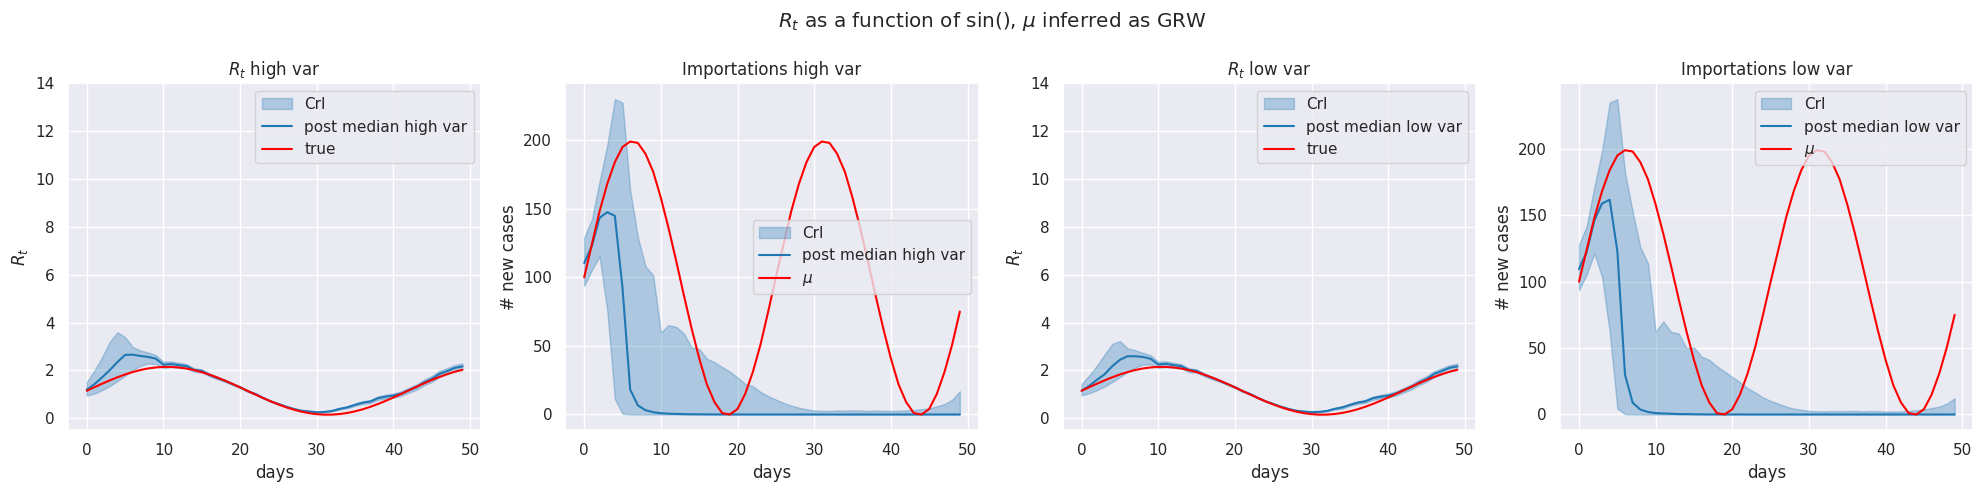

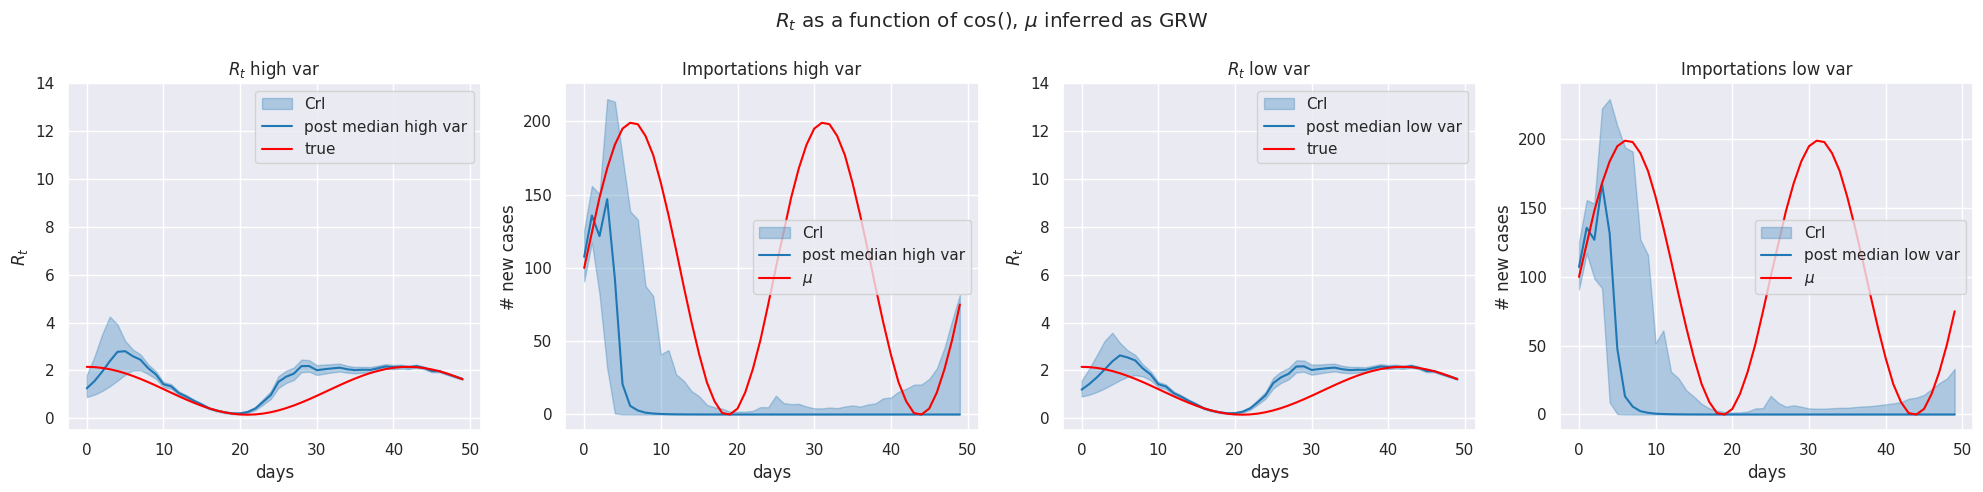

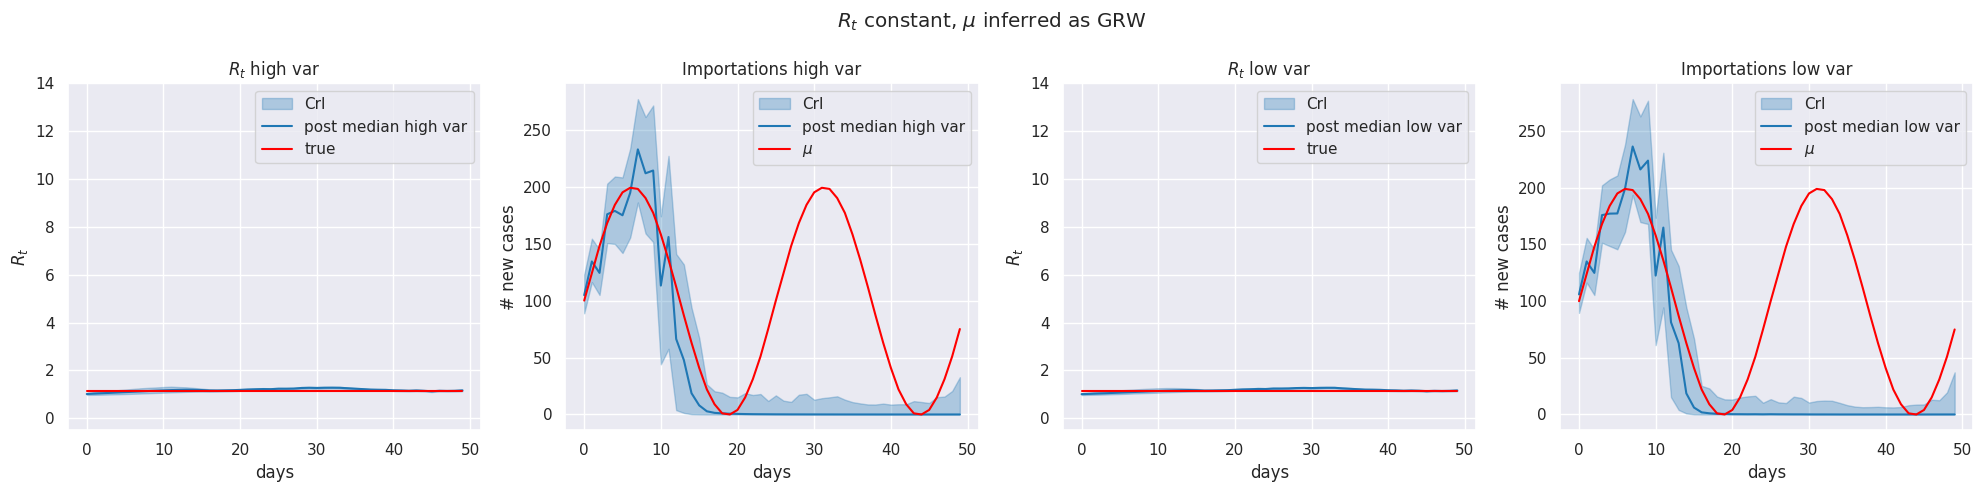

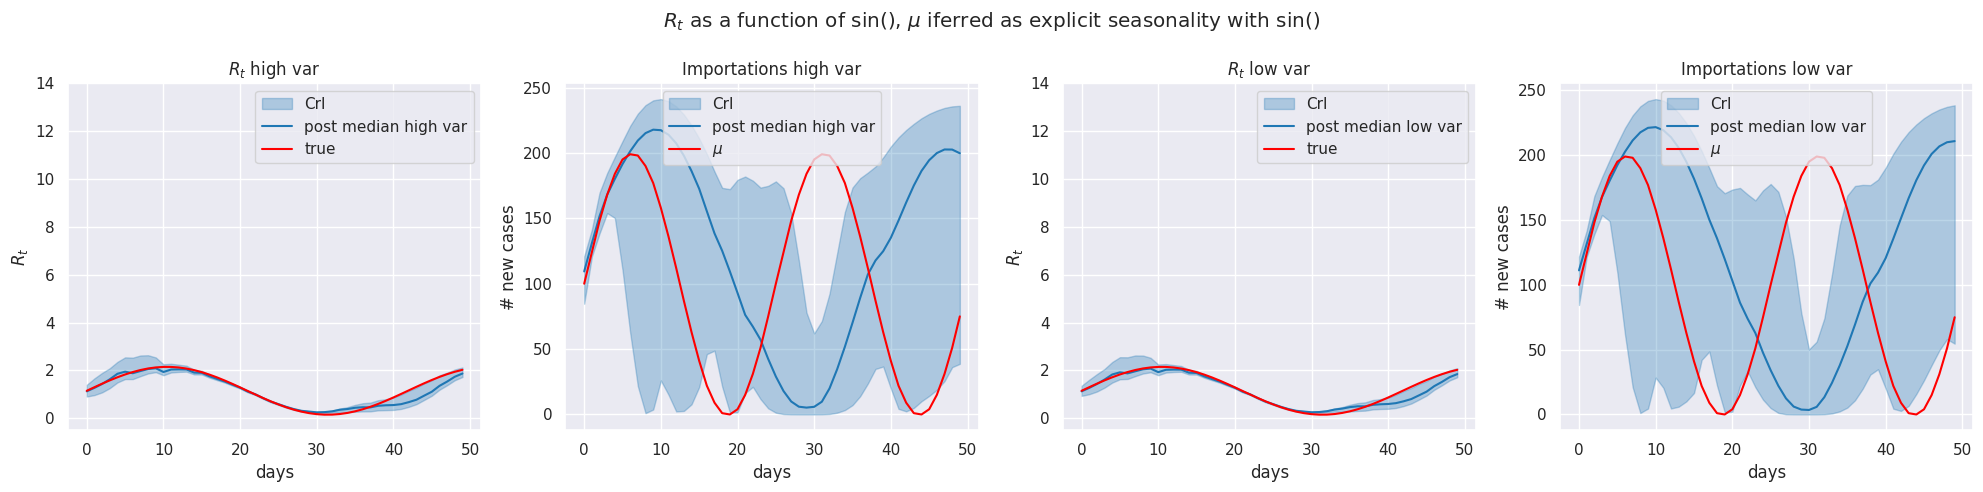

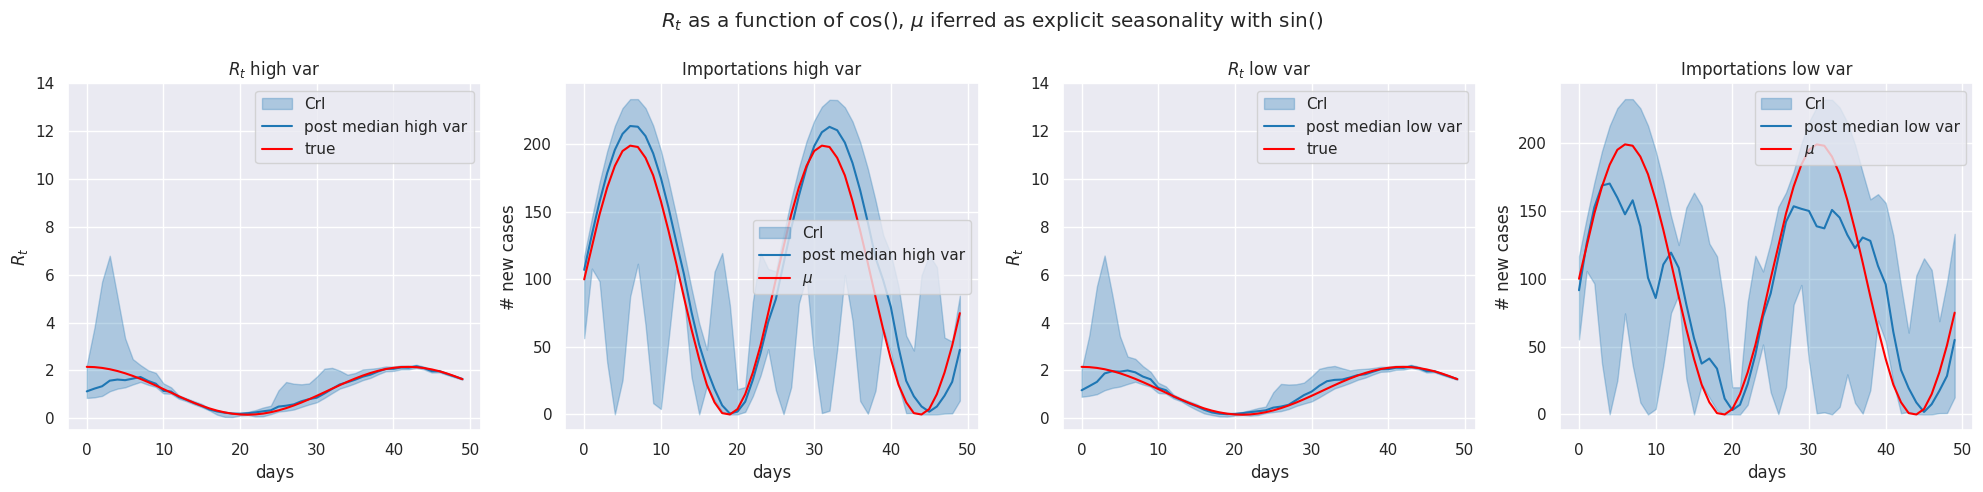

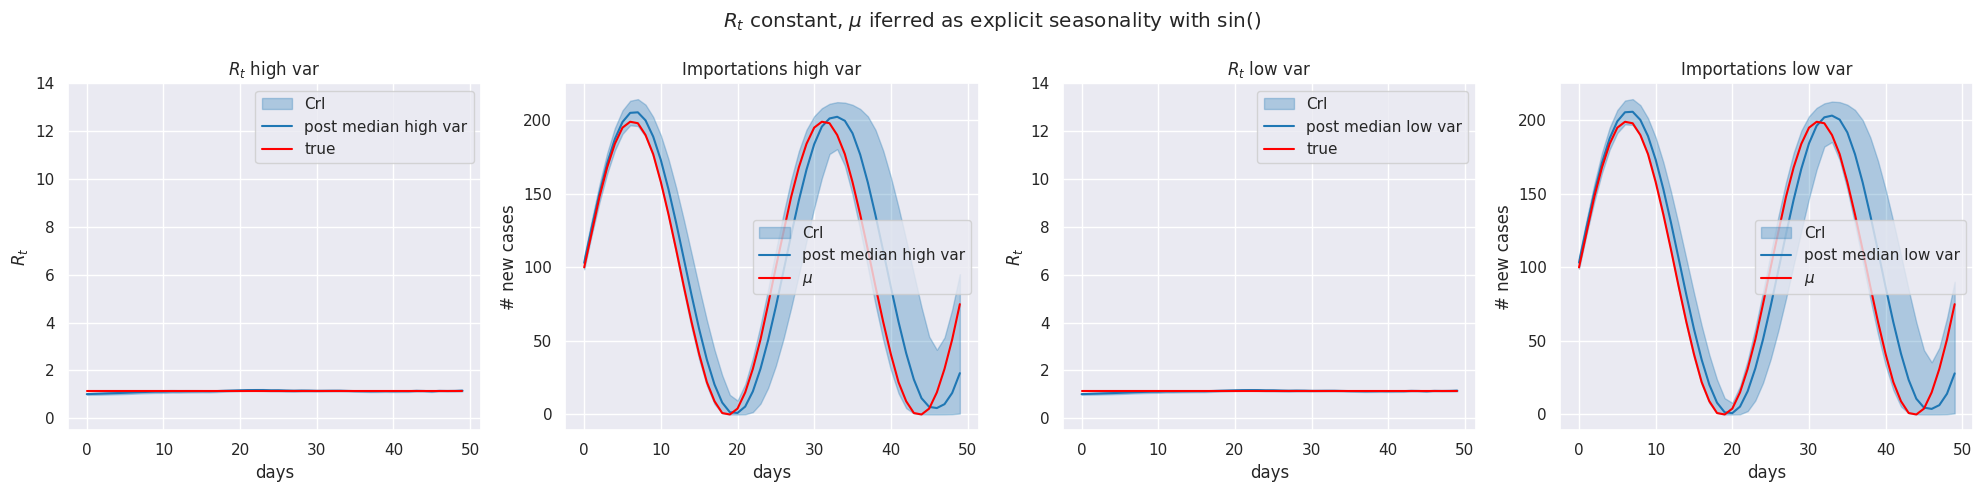

In [ ]:
plot_posterior_two_samples(samples1, samples10, R1, mu1, inc1, title=scenarios_names[1])
plot_posterior_two_samples(samples2, samples20, R2, mu2, inc2, title=scenarios_names[2])
plot_posterior_two_samples(samples3, samples30, R3, mu3, inc3, title=scenarios_names[3])

plot_posterior_two_samples(samples1e, samples10e, R1, mu1, inc1, title=scenarios_names[4])
plot_posterior_two_samples(samples2e, samples20e, R2, mu2, inc2, title=scenarios_names[5])
plot_posterior_two_samples(samples3e, samples30e, R3, mu3, inc3, title=scenarios_names[6])

# plot_posterior_two_samples(samples7, samples70, R7, mu7, inc7, title=scenarios_names[7])
# plot_posterior_two_samples(samples8, samples80, R8, mu8, inc8, title=scenarios_names[8])
# plot_posterior_two_samples(samples9, samples90, R9, mu9, inc9, title=scenarios_names[9])


# Test different priors for R_t variance

In [ ]:
assert(1==2)

SyntaxError: ignored

In [ ]:
r_var = [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 20.0, 50.0]
samples_dict = {}

In [ ]:
for rv in r_var:
  print(rv)
  s = fit(renewal, obs, g, r_prior=rv)
  samples_dict.update({rv: s})

In [ ]:
for rv in r_var:
  s = samples_dict[rv]
  plot_posterior(s, 'R_t variance ~ Exp(' + str(rv) + ')')

# Plot in one image


In [ ]:
def plot_posterior(samples, title=None):
  plt.figure(figsize=(15,5))

  x = np.arange(n)
  plt.subplot(1,3,1)
  # plt.plot(samples['R'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['R'], 5, axis=0), np.percentile(samples['R'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['R'], 50, axis=0), label='post median', color='tab:blue')
  plt.plot(R, color = 'red', alpha=1.0, label = 'true')
  # plt.legend()
  plt.ylim(-0.5,14)
  plt.xlabel('days')
  plt.ylabel(r'$R_t$')
  plt.title(r'$R_t$')

  plt.subplot(1,3,2)
  # plt.plot(samples['mu'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['mu'], 5, axis=0), np.percentile(samples['mu'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['mu'], 50, axis=0), label='post median', color='tab:blue')
  plt.plot(mu, color = 'red', alpha=1.0, label = 'true')
  # plt.legend()
  # plt.ylim(0,np.max((samples['mu'].max(), mu.max()))*1.1)
  # plt.ylim(0, mu.max() * 2)
  plt.xlabel('days')
  plt.ylabel('# importations')
  plt.title('Importations')

  plt.subplot(1,3,3)
  # plt.plot(samples['incidence'][0::100,:].T, color = 'b', alpha=0.5, label = 'posterior')
  plt.fill_between(x, np.percentile(samples['incidence'], 5, axis=0), np.percentile(samples['incidence'], 95, axis=0), alpha=0.3, label='CrI', color='tab:blue')
  plt.plot(x, np.percentile(samples['incidence'], 50, axis=0), label='posterior median', color='tab:blue')
  plt.plot(inc, color = 'red', alpha=1.0, label = 'true')
  # plt.ylim(0,samples['incidence'].max())
  plt.legend()
  plt.xlabel('days')
  plt.ylabel('# new cases')
  plt.title('Incidence')


  if title is None:
    plt.suptitle('Posterior predictive')
  else:
    plt.suptitle('Posterior predictive, ' + title)
  plt.tight_layout()
  plt.show()

In [ ]:
samples_dict.keys()

In [ ]:
r_var_plots = [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 20.0, 50.0]

In [ ]:
for rv in r_var:
  s = samples_dict[rv]
  plot_posterior(s, 'R_t variance ~ Exp(' + str(rv) + ')')